# Translational Symmetry Regularization

Simple experiment: Ring attractor data with translational symmetry regularization.

- **Data**: Ring attractor (perturbation = 0.1)
- **Target field**: Translational symmetry in x-direction
- **Lambda**: 1e-1

In [29]:
# Setup
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

from regularized_ssm import RegularizedSSM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

SEED = 41
torch.manual_seed(SEED)
np.random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [30]:
# Config
class Config:
    n_latents = 2
    n_latents_read = 2
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    n_samples = 5
    batch_sz = 32
    learning_rate = 1e-3
    max_epochs = 25
    patience = 5
    grad_clip = 1.0
    
    n_trials = 1000
    n_neurons = 100
    n_time_bins = 75
    train_split = 0.8
    
    # Experiment parameters
    perturbation_magnitude = 0.1
    lambda_lie = 1e-1
    
    seed = SEED

cfg = Config()
print(f"Perturbation: {cfg.perturbation_magnitude}")
print(f"Lambda: {cfg.lambda_lie}")

Perturbation: 0.1
Lambda: 0.1


In [31]:
# Load ring attractor dynamics
import importlib.util

spec = importlib.util.spec_from_file_location("test_dynamics", "test_dynamics.py")
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

print("Ring attractor dynamics loaded")

Ring attractor dynamics loaded


In [32]:
# Create TranslationInvarianceRegularizer
class TranslationInvarianceRegularizer:
    """
    Regularizer that enforces translational invariance: f(x + δ) ≈ f(x)
    """
    
    def __init__(self, dynamics_fn, translation_scale=0.1, direction='x'):
        """
        Args:
            dynamics_fn: The dynamics function f(x) to regularize
            translation_scale: Scale of random translations
            direction: 'x', 'y', or 'both'
        """
        self.dynamics_fn = dynamics_fn
        self.translation_scale = translation_scale
        self.direction = direction
    
    def sample_translation(self, batch_size, device):
        """Sample random translation vectors in x-direction."""
        delta_x = torch.rand(batch_size, device=device) * 2 * self.translation_scale - self.translation_scale
        delta = torch.zeros(batch_size, 2, device=device)
        
        if self.direction == 'x':
            delta[:, 0] = delta_x
        elif self.direction == 'y':
            delta[:, 1] = delta_x
        else:  # both
            delta_y = torch.rand(batch_size, device=device) * 2 * self.translation_scale - self.translation_scale
            delta[:, 0] = delta_x
            delta[:, 1] = delta_y
            
        return delta
    
    def __call__(self, x):
        """
        Compute translational invariance loss: ||f(x + δ) - f(x)||²
        
        Args:
            x: Input tensor of shape [batch_size, 2]
            
        Returns:
            Scalar loss value
        """
        batch_size = x.shape[0]
        device = x.device
        
        # Sample translation
        delta = self.sample_translation(batch_size, device)
        
        # Compute f(x) and f(x + δ)
        fx = self.dynamics_fn(x)
        fx_translated = self.dynamics_fn(x + delta)
        
        # Compute violation: ||f(x + δ) - f(x)||²
        violation = torch.norm(fx_translated - fx, dim=-1) ** 2
        
        return violation.mean()

print("✅ TranslationInvarianceRegularizer created")
print("   Enforces: ||f(x + δ) - f(x)|| ≈ 0 where δ = [δx, 0]")

✅ TranslationInvarianceRegularizer created
   Enforces: ||f(x + δ) - f(x)|| ≈ 0 where δ = [δx, 0]


In [33]:
# Generate data
print("Generating ring attractor data...")

data_gen_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1,
    lengthscale=0.2,
    perturbation_magnitude=cfg.perturbation_magnitude
).to(device)

C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)
R_diag = 1e-1 * torch.ones(cfg.n_neurons, device=device)
m_0 = torch.zeros(cfg.n_latents, device=device)

z_true = utils.sample_gauss_z(data_gen_dynamics, Q_diag, m_0, Q_0_diag, cfg.n_trials, cfg.n_time_bins)
y = C(z_true) + torch.sqrt(R_diag) * torch.randn((cfg.n_trials, cfg.n_time_bins, cfg.n_neurons), device=device)
y = y.detach()

n_train = int(cfg.train_split * cfg.n_trials)
y_train = y[:n_train]
y_valid = y[n_train:]

print(f"Train: {y_train.shape[0]} trials")
print(f"Valid: {y_valid.shape[0]} trials")

Generating ring attractor data...
Train: 800 trials
Valid: 200 trials


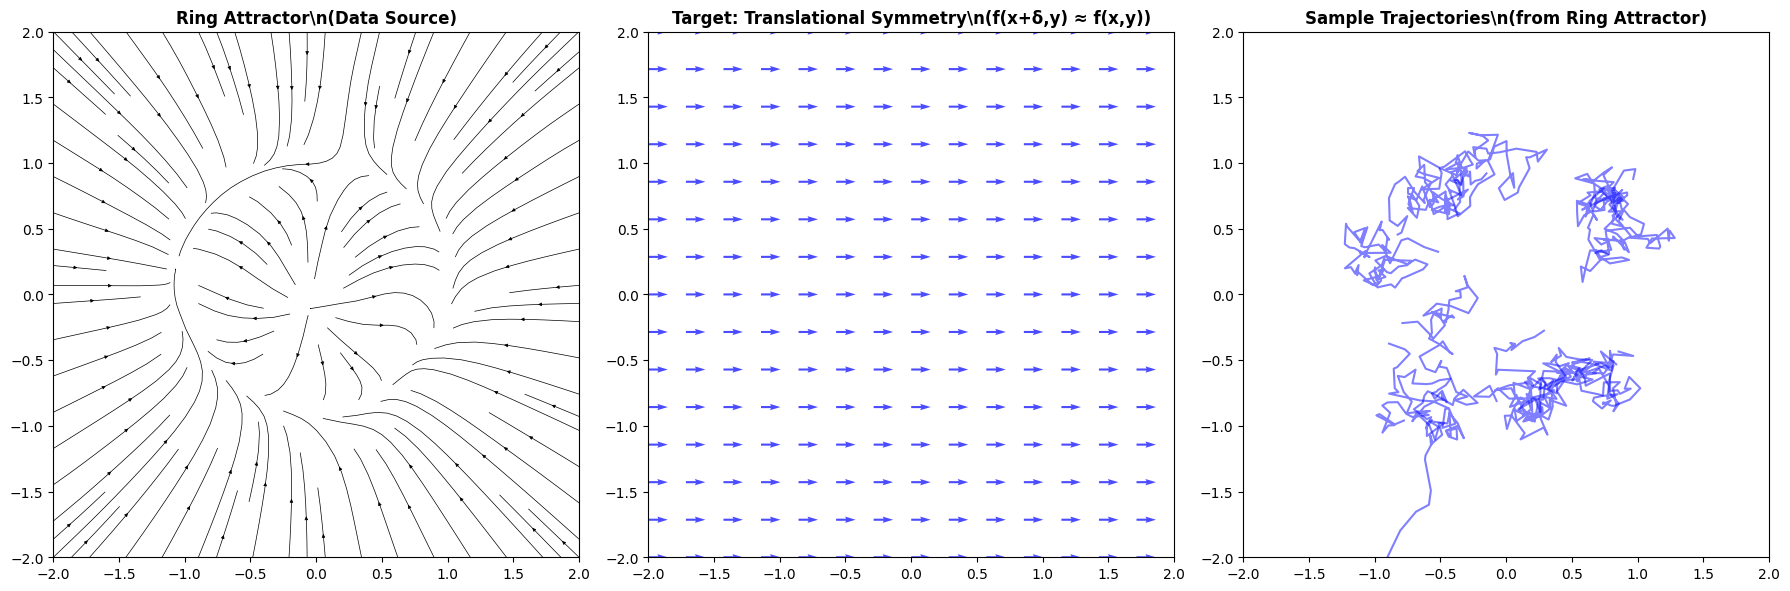

Setup complete!


In [34]:
# Visualize setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ring attractor
ax = axes[0]
plot_utils.plot_two_d_vector_field(data_gen_dynamics.to('cpu'), ax, min_xy=-2, max_xy=2)
ax.set_title('Ring Attractor\\n(Data Source)', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Target translational symmetry (not a field, but a constraint)
ax = axes[1]
x_grid = np.linspace(-2, 2, 15)
y_grid = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x_grid, y_grid)
# Show concept: arrows point in same direction (translation invariant)
U = np.ones_like(X)
V = np.zeros_like(Y)
ax.quiver(X, Y, U, V, color='blue', alpha=0.7)
ax.set_title('Target: Translational Symmetry\\n(f(x+δ,y) ≈ f(x,y))', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Sample trajectories
ax = axes[2]
for i in range(10):
    ax.plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 'b-', alpha=0.5)
ax.set_title('Sample Trajectories\\n(from Ring Attractor)', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Setup complete!")

In [35]:
# Create model with TranslationInvarianceRegularizer
class TranslationRegularizedSSM(RegularizedSSM):
    """SSM with translational invariance regularization."""
    
    def __init__(self, dynamics_mod, likelihood_pdf, initial_c_pdf, backward_encoder,
                 local_encoder, nl_filter, lambda_translation=0.0,
                 translation_scale=0.1, device='cpu', **kwargs):
        
        # Initialize parent WITHOUT target_vector_field
        super().__init__(
            dynamics_mod=dynamics_mod,
            likelihood_pdf=likelihood_pdf,
            initial_c_pdf=initial_c_pdf,
            backward_encoder=backward_encoder,
            local_encoder=local_encoder,
            nl_filter=nl_filter,
            device=device,
            **kwargs
        )
        
        self.lambda_translation = lambda_translation
        self.translation_scale = translation_scale
        
        # Create translational regularizer
        if lambda_translation > 0:
            self.translation_regularizer = TranslationInvarianceRegularizer(
                dynamics_fn=self.dynamics_mod.mean_fn,
                translation_scale=translation_scale,
                direction='x'
            )
        else:
            self.translation_regularizer = None
    
    def forward(self, observations, n_samples):
        """Forward pass with translational regularization."""
        # Get base ELBO loss from parent
        elbo_loss, z_s, stats = super().forward(observations, n_samples)
        
        # Add translational regularization
        translation_loss = torch.tensor(0.0, device=self.device)
        
        if self.lambda_translation > 0 and self.translation_regularizer is not None:
            # Use mean of samples for regularization (same as RegularizedSSM)
            z_mean = z_s.mean(dim=0)  # [n_trials, n_time, n_latents]
            # Flatten to [n_trials * n_time, n_latents]
            z_flat = z_mean.reshape(-1, z_mean.shape[-1])
            
            # Compute translational regularization
            translation_loss = self.translation_regularizer(z_flat)
            
            # Add to stats
            stats['translation_loss'] = translation_loss
        
        # Total loss
        total_loss = elbo_loss + self.lambda_translation * translation_loss
        stats['total_loss'] = total_loss
        
        return total_loss, z_s, stats


def create_ssm(lambda_translation):
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    ssm = TranslationRegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        lambda_translation=lambda_translation,
        translation_scale=0.1,  # Scale of random translations
        device=device
    )
    return ssm

ssm = create_ssm(cfg.lambda_lie)
print(f"Model created with λ_translation = {cfg.lambda_lie}")

Model created with λ_translation = 0.1


In [36]:
# Training
def train_model(ssm, y_train, y_valid):
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    best_valid_elbo = float('inf')
    patience_counter = 0
    best_model_state = None
    
    history = defaultdict(list)
    
    print("Training...")
    for epoch in range(1, cfg.max_epochs + 1):
        # Train
        ssm.train()
        train_losses = []
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        train_stats = {k: torch.stack([b[k] for b in train_losses]).mean() for k in train_losses[0].keys()}
        
        # Valid
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        # Track - only scalar values
        for k in train_stats.keys():
            if train_stats[k].numel() == 1:  # Only track scalars
                history[f'train_{k}'].append(train_stats[k].item())
                if valid_stats[k].numel() == 1:
                    history[f'valid_{k}'].append(valid_stats[k].item())
        
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
            best_model_state = {k: v.cpu() for k, v in ssm.state_dict().items()}
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            trans_loss = valid_stats.get('translation_loss', torch.tensor(0.0))
            trans_str = f", Translation = {trans_loss.item():.3e}" if trans_loss.numel() == 1 else ""
            print(f"Epoch {epoch}: Valid ELBO = {current_valid_elbo:.3f}{trans_str}, Patience = {patience_counter}/{cfg.patience}")
        
        if patience_counter >= cfg.patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if best_model_state is not None:
        ssm.load_state_dict(best_model_state)
        print(f"Restored best model (ELBO: {best_valid_elbo:.6f})")
    
    return history

history = train_model(ssm, y_train, y_valid)

Training...
Epoch 5: Valid ELBO = 3876.185, Translation = 2.961e-03, Patience = 0/5
Epoch 10: Valid ELBO = 2661.062, Translation = 2.916e-03, Patience = 0/5
Epoch 15: Valid ELBO = 2481.904, Translation = 2.798e-03, Patience = 0/5
Epoch 20: Valid ELBO = 2391.754, Translation = 2.749e-03, Patience = 1/5
Epoch 25: Valid ELBO = 2350.390, Translation = 2.678e-03, Patience = 0/5
Restored best model (ELBO: 2350.389648)


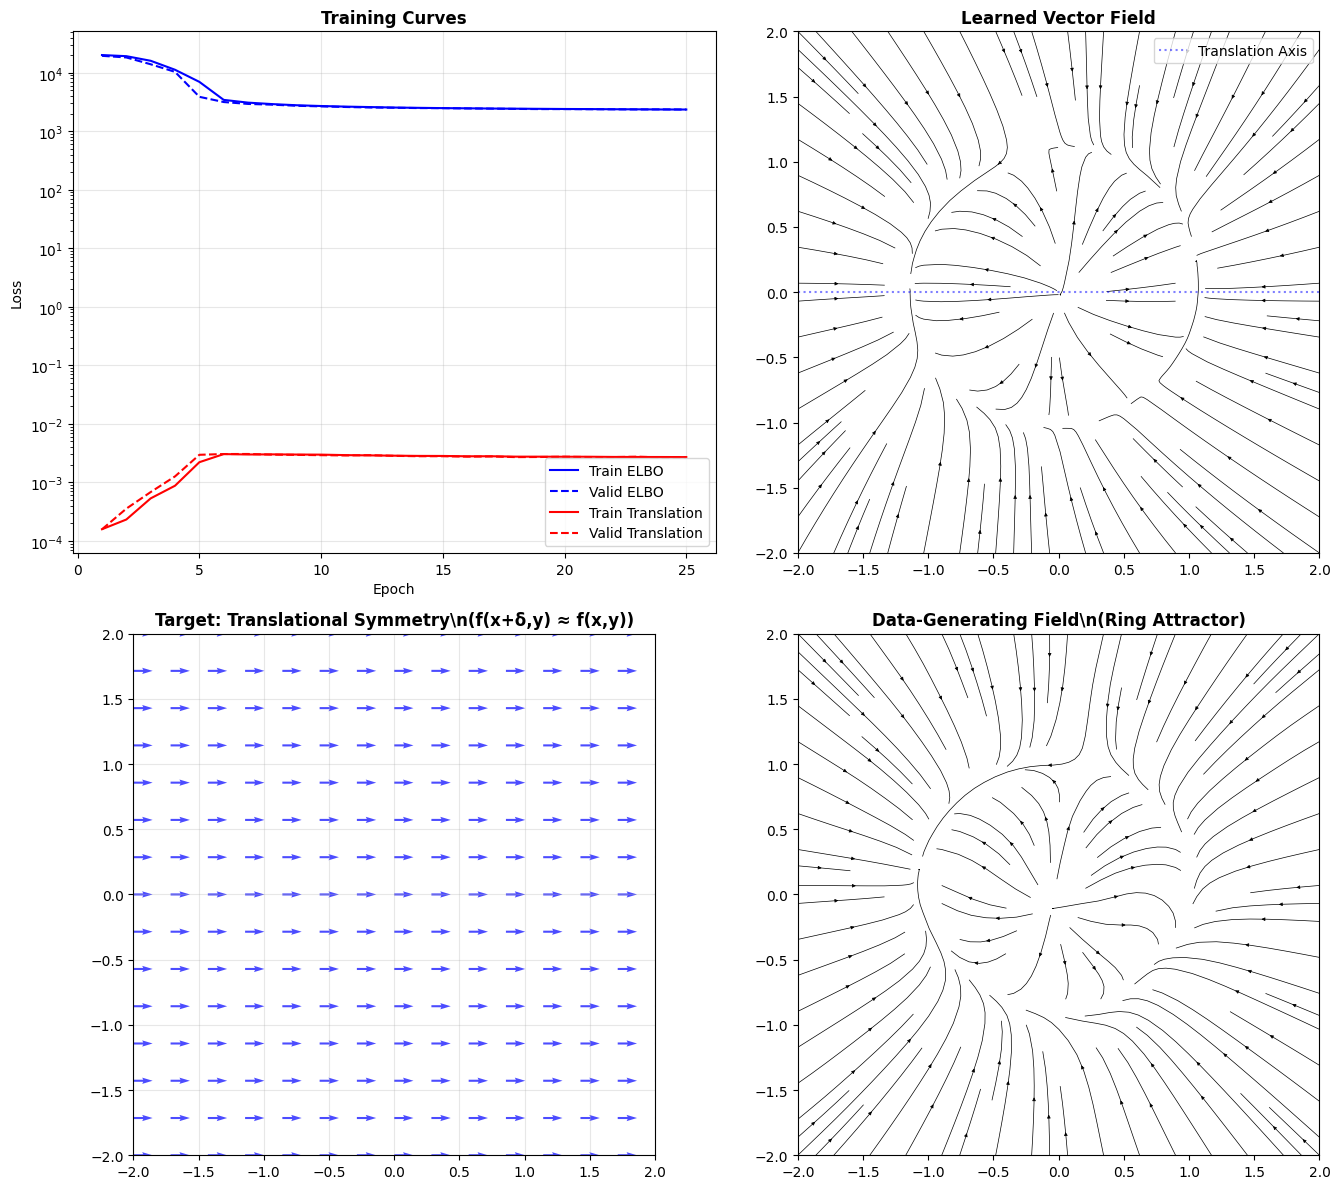


Final results:
  Valid ELBO: 2350.390
  Valid Translation: 2.678e-03

Saved: translational_symmetry_results.png


In [37]:
# Results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Training curves
ax = axes[0, 0]
epochs = range(1, len(history['train_elbo_loss']) + 1)
ax.semilogy(epochs, history['train_elbo_loss'], 'b-', label='Train ELBO')
ax.semilogy(epochs, history['valid_elbo_loss'], 'b--', label='Valid ELBO')
if 'train_translation_loss' in history and len(history['train_translation_loss']) > 0:
    ax.semilogy(epochs, history['train_translation_loss'], 'r-', label='Train Translation')
    ax.semilogy(epochs, history['valid_translation_loss'], 'r--', label='Valid Translation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curves', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Learned vector field
ax = axes[0, 1]
ssm.eval()
plot_utils.plot_two_d_vector_field(ssm.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
ax.set_title('Learned Vector Field', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
# Add reference for translational symmetry
ax.axhline(y=0, color='blue', linewidth=1.5, label='Translation Axis', alpha=0.5, linestyle=':')
ax.legend()

# Target translational field visualization
ax = axes[1, 0]
x_grid = np.linspace(-2, 2, 15)
y_grid = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x_grid, y_grid)
# Show constant horizontal arrows (translational symmetry in x)
U = np.ones_like(X)
V = np.zeros_like(Y)
ax.quiver(X, Y, U, V, color='blue', alpha=0.7)
ax.set_title('Target: Translational Symmetry\\n(f(x+δ,y) ≈ f(x,y))', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Data-generating field
ax = axes[1, 1]
plot_utils.plot_two_d_vector_field(data_gen_dynamics.to('cpu'), ax, min_xy=-2, max_xy=2)
ax.set_title('Data-Generating Field\\n(Ring Attractor)', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('translational_symmetry_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFinal results:")
print(f"  Valid ELBO: {history['valid_elbo_loss'][-1]:.3f}")
if 'valid_translation_loss' in history and len(history['valid_translation_loss']) > 0:
    print(f"  Valid Translation: {history['valid_translation_loss'][-1]:.3e}")
print(f"\nSaved: translational_symmetry_results.png")